In [1]:
import statistics as st
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from IPython.core.display import display, HTML
import re
import dateutil.parser
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:

def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)

def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))
        
    
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [3]:
#import data

final_df= pd.read_csv('linreg_final_df.csv')

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYER          1283 non-null   object 
 1   GAMES           1283 non-null   int64  
 2   MINUTES_PLAYED  1283 non-null   float64
 3   FIELD_GOALS     1283 non-null   float64
 4   FIELD_GOAL_PCT  1283 non-null   float64
 5   3PT_M           1283 non-null   float64
 6   3PT_PCT         1283 non-null   float64
 7   2PT_M           1283 non-null   float64
 8   2PT_PCT         1283 non-null   float64
 9   FT_M            1283 non-null   float64
 10  FT_PCT          1283 non-null   float64
 11  OFF_REB         1283 non-null   float64
 12  DEF_REB         1283 non-null   float64
 13  TOT_REB         1283 non-null   float64
 14  ASSISTS         1283 non-null   float64
 15  STEALS          1283 non-null   float64
 16  BLOCKS          1283 non-null   float64
 17  TO              1283 non-null   f

In [5]:
#drop columns that will not be included in my features (non-continuous or clear colinearity)

final_df_2 = final_df.drop(['GAMES','MINUTES_PLAYED','YEAR','TEAM_x','CONTRACT_LEN','EXPIRES',
                            'YEAR_SIGNED','FIELD_GOAL_PCT'], axis = 1)

final_df_2['SALARY'].median()
#median = 6006600.0
final_df_2['SALARY'].describe()
final_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER        1283 non-null   object 
 1   FIELD_GOALS   1283 non-null   float64
 2   3PT_M         1283 non-null   float64
 3   3PT_PCT       1283 non-null   float64
 4   2PT_M         1283 non-null   float64
 5   2PT_PCT       1283 non-null   float64
 6   FT_M          1283 non-null   float64
 7   FT_PCT        1283 non-null   float64
 8   OFF_REB       1283 non-null   float64
 9   DEF_REB       1283 non-null   float64
 10  TOT_REB       1283 non-null   float64
 11  ASSISTS       1283 non-null   float64
 12  STEALS        1283 non-null   float64
 13  BLOCKS        1283 non-null   float64
 14  TO            1283 non-null   float64
 15  POINTS        1283 non-null   float64
 16  POSITION      1283 non-null   object 
 17  EXPERIENCE    1283 non-null   float64
 18  SALARY        1283 non-null 

In [6]:
#to get rid of outliers 
final_df_3 = final_df_2.drop(final_df_2[final_df_2["SALARY"]>(14575850+18370980)].index)
final_df_3 = final_df_3.drop(final_df_3[final_df_3["SALARY"]<(2328530-18370980)].index)

final_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1282
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER        1276 non-null   object 
 1   FIELD_GOALS   1276 non-null   float64
 2   3PT_M         1276 non-null   float64
 3   3PT_PCT       1276 non-null   float64
 4   2PT_M         1276 non-null   float64
 5   2PT_PCT       1276 non-null   float64
 6   FT_M          1276 non-null   float64
 7   FT_PCT        1276 non-null   float64
 8   OFF_REB       1276 non-null   float64
 9   DEF_REB       1276 non-null   float64
 10  TOT_REB       1276 non-null   float64
 11  ASSISTS       1276 non-null   float64
 12  STEALS        1276 non-null   float64
 13  BLOCKS        1276 non-null   float64
 14  TO            1276 non-null   float64
 15  POINTS        1276 non-null   float64
 16  POSITION      1276 non-null   object 
 17  EXPERIENCE    1276 non-null   float64
 18  SALARY        1276 non-null 

In [7]:
#Creating Dummy Variable for Position

final_df_3 = pd.get_dummies(final_df_2,columns=['POSITION'])

final_df_3.tail()

,PLAYER,FIELD_GOALS,3PT_M,3PT_PCT,2PT_M,2PT_PCT,FT_M,FT_PCT,OFF_REB,DEF_REB,...,TO,POINTS,EXPERIENCE,SALARY,CONTRACT_TOT,POSITION_C,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
1278,montrezl harrell,3.9,0.0,0.143,3.9,0.663,1.3,0.628,1.4,2.4,...,0.8,9.1,1.0,1045000.0,18978900.0,1,0,0,0,0
1279,montrezl harrell,3.9,0.0,0.143,3.9,0.663,1.3,0.628,1.4,2.4,...,0.8,9.1,1.0,1045000.0,18978900.0,1,0,0,0,0
1280,montrezl harrell,3.9,0.0,0.143,3.9,0.663,1.3,0.628,1.4,2.4,...,0.8,9.1,1.0,1045000.0,18978900.0,1,0,0,0,0
1281,montrezl harrell,3.9,0.0,0.143,3.9,0.663,1.3,0.628,1.4,2.4,...,0.8,9.1,1.0,1045000.0,18978900.0,1,0,0,0,0
1282,montrezl harrell,3.9,0.0,0.143,3.9,0.663,1.3,0.628,1.4,2.4,...,0.8,9.1,1.0,1045000.0,18978900.0,1,0,0,0,0


In [8]:
#pairplot

sns.set(font_scale=2) 
sns.pairplot(final_df_3)

In [9]:
#look at correlated features

final_df_3.corr()

,FIELD_GOALS,3PT_M,3PT_PCT,2PT_M,2PT_PCT,FT_M,FT_PCT,OFF_REB,DEF_REB,TOT_REB,...,TO,POINTS,EXPERIENCE,SALARY,CONTRACT_TOT,POSITION_C,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
FIELD_GOALS,1.000000,0.451320,0.091596,0.917210,0.108365,0.825899,0.270152,0.252873,0.537918,0.478092,...,0.773358,0.981651,0.294437,0.607900,0.622058,-0.040436,-0.041185,0.061540,-0.008853,0.037400
3PT_M,0.451320,1.000000,0.490609,0.059086,-0.274326,0.345823,0.509919,-0.455831,-0.053194,-0.192790,...,0.375328,0.546131,0.271568,0.306542,0.369260,-0.519855,-0.078466,0.165434,0.173519,0.316047
3PT_PCT,0.091596,0.490609,1.000000,-0.118535,-0.328734,0.023217,0.382175,-0.412334,-0.207284,-0.289790,...,0.044340,0.138131,0.130334,0.070161,0.071801,-0.532653,0.144709,0.106836,0.163697,0.158223
2PT_M,0.917210,0.059086,-0.118535,1.000000,0.245615,0.768692,0.074511,0.484590,0.623872,0.619082,...,0.697229,0.854278,0.207161,0.541998,0.530103,0.185378,-0.011490,-0.005282,-0.086085,-0.098206
2PT_PCT,0.108365,-0.274326,-0.328734,0.245615,1.000000,0.024360,-0.251083,0.466330,0.292250,0.370930,...,-0.060368,0.044376,0.067334,0.042488,0.045378,0.503349,0.024020,-0.311455,-0.092558,-0.179915
FT_M,0.825899,0.345823,0.023217,0.768692,0.024360,1.000000,0.299812,0.181765,0.494882,0.422496,...,0.782185,0.892397,0.272942,0.595000,0.662993,-0.043714,-0.090263,0.154264,0.020333,-0.025688
FT_PCT,0.270152,0.509919,0.382175,0.074511,-0.251083,0.299812,1.000000,-0.342242,-0.097669,-0.185039,...,0.156361,0.339730,0.134042,0.162847,0.238771,-0.350045,-0.038664,0.123777,0.121239,0.181268
OFF_REB,0.252873,-0.455831,-0.412334,0.484590,0.466330,0.181765,-0.342242,1.000000,0.718967,0.862988,...,0.175288,0.161308,0.080273,0.190524,0.014028,0.629528,0.064871,-0.275984,-0.179545,-0.308027
DEF_REB,0.537918,-0.053194,-0.207284,0.623872,0.292250,0.494882,-0.097669,0.718967,1.000000,0.971372,...,0.508517,0.499992,0.289539,0.477305,0.276968,0.346677,0.124600,-0.212438,-0.042329,-0.262856
TOT_REB,0.478092,-0.192790,-0.289790,0.619082,0.370930,0.422496,-0.185039,0.862988,0.971372,1.000000,...,0.428038,0.419415,0.237650,0.412848,0.207236,0.467082,0.111548,-0.249017,-0.091959,-0.294901


In [10]:
#first list of features with all highly correlation to the target

features_1 = ['2PT_M','3PT_M','FT_M','DEF_REB','OFF_REB','ASSISTS',
       'STEALS','TO','EXPERIENCE','BLOCKS','POSITION_PG','POSITION_SG','POSITION_PF','POSITION_SF',
           'POSITION_C','SALARY']

['2PT_M','3PT_M','FT_M','DEF_REB','OFF_REB','ASSISTS',
       'STEALS','TO','EXPERIENCE','BLOCKS','POSITION_PG','POSITION_SG','POSITION_SF','POSITION_PF',
                    'POSITION_C','SALARY']

model_df = final_df_3.reindex(columns = features_1)



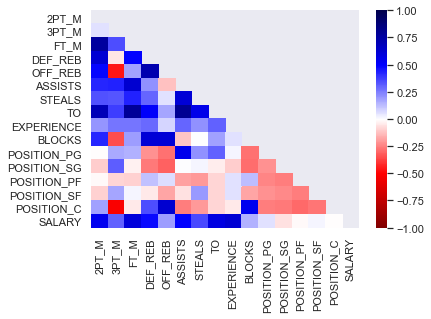

In [11]:
#heatmap of correlations
sns.set(font_scale=1)

upper = np.triu(model_df.corr())
sns.heatmap(final_df_3[features_1].corr(), cmap="seismic_r", vmin=-1, vmax=1, mask=upper);

In [12]:
#checking for multicolinearity 
vif(model_df)

2PT_M          4.129458
3PT_M          2.341601
FT_M           4.114094
DEF_REB        4.364006
OFF_REB        4.545952
ASSISTS        5.717972
STEALS         2.056723
TO             6.114857
EXPERIENCE     1.794835
BLOCKS         2.382567
POSITION_PG    3.228065
POSITION_SG    3.021212
POSITION_PF    3.501927
POSITION_SF    3.311328
POSITION_C     4.962456
SALARY         2.650558
dtype: float64

In [13]:
#updated features to reduce multicolinearity
features_2 = ['FIELD_GOALS','FT_M','DEF_REB', 'ASSISTS',
       'STEALS', 'BLOCKS', 'EXPERIENCE','POSITION_PG','POSITION_SG','POSITION_PF','POSITION_SF',
           'POSITION_C','TO','SALARY']
model_df = final_df_3.reindex(columns = features_2)

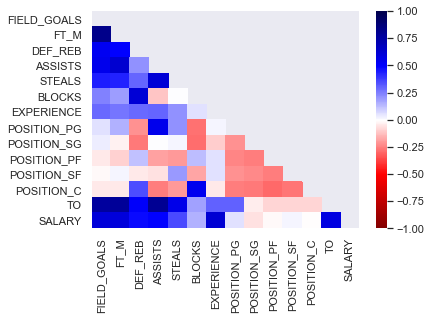

In [14]:
#heatmap of updated correlations

upper = np.triu(model_df.corr())
sns.heatmap(model_df.corr(), cmap="seismic_r", vmin=-1, vmax=1, mask=upper);

In [15]:
#checking for updated multicolinearity

vif(model_df)

FIELD_GOALS    4.208270
FT_M           4.035935
DEF_REB        3.015619
ASSISTS        5.396179
STEALS         1.979286
BLOCKS         2.279688
EXPERIENCE     1.726001
POSITION_PG    3.161817
POSITION_SG    2.736033
POSITION_PF    3.453925
POSITION_SF    3.133911
POSITION_C     4.366934
TO             6.103960
SALARY         2.644442
dtype: float64

In [16]:
#throwing back in features to add complexity
features_3 = features_1

# ['FIELD_GOALS','FT_M', 'ASSISTS','STEALS', 'BLOCKS', 'EXPERIENCE','POSITION_PG','DEF_REB',
#               'POSITION_SG','POSITION_PF','POSITION_SF','POSITION_C',"SALARY",]
model_df = final_df_3.reindex(columns = features_3)

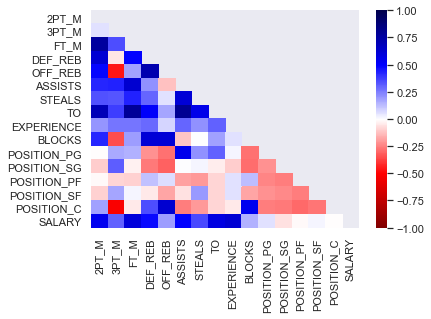

In [17]:
upper = np.triu(model_df.corr())
sns.heatmap(model_df.corr(), cmap="seismic_r", vmin=-1, vmax=1, mask=upper);

In [18]:
vif(model_df)

2PT_M          4.129458
3PT_M          2.341601
FT_M           4.114094
DEF_REB        4.364006
OFF_REB        4.545952
ASSISTS        5.717972
STEALS         2.056723
TO             6.114857
EXPERIENCE     1.794835
BLOCKS         2.382567
POSITION_PG    3.228065
POSITION_SG    3.021212
POSITION_PF    3.501927
POSITION_SF    3.311328
POSITION_C     4.962456
SALARY         2.650558
dtype: float64

In [19]:
#assigning x and y to features and target
X = model_df.iloc[:,0:15]

# Pick the target
y = model_df["SALARY"]


In [20]:
#train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

In [21]:
#creating kfold object for cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 13)

In [22]:
#create a linear model

lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_train, y_train)

0.6247946038249126

In [23]:
#average cross val r2 for linear model on train

np.mean(cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric



0.6053447294659484

In [24]:
#determine optimal alpha for ridge regression

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.values, y_train)
    
    val_set_pred = pipe.predict(X_test.values)
    err_vec_val[i] = RMSE(y_test, val_set_pred)

In [25]:
np.min(err_vec_val)
opt_alpha = alphalist[np.argmin(err_vec_val)]
opt_alpha

0.01

In [26]:
#standardize x data and transform onto test
scaler = StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)


In [27]:
#create ridge regression with optimal alpha fit to 

lm_ridge = Ridge(alpha=opt_alpha)
lm_ridge.fit(X_train_scaled,y_train)

Ridge(alpha=0.01)

In [28]:
#average cross val r2 for ridge regression on train (linear avg was .6025553368305263)

np.mean(cross_val_score(lm_ridge, X_train, y_train, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric

0.6053455989329498

In [29]:
#checking scores for linear and ridge on entire dataset (ridge better)

kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_ridge, X, y, cv=kf, scoring='r2')))

0.6056393618636852
0.6056402841022513


In [30]:
#checking scores for linear and ridge on test set(ridge better)

kf = KFold(n_splits=5, shuffle=True, random_state = 13)

print(np.mean(cross_val_score(lm, X_test, y_test, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_ridge, X_test, y_test, cv=kf, scoring='r2')))

0.5862109897056762
0.586228925728601


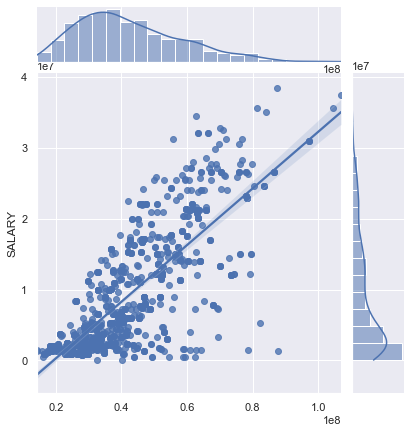

In [31]:
#generate predictions

preds_train = lm_ridge.predict(X_train) # generate predictions (on training data) using fit model

sns.jointplot(x=preds_train,y=y_train, kind='reg')

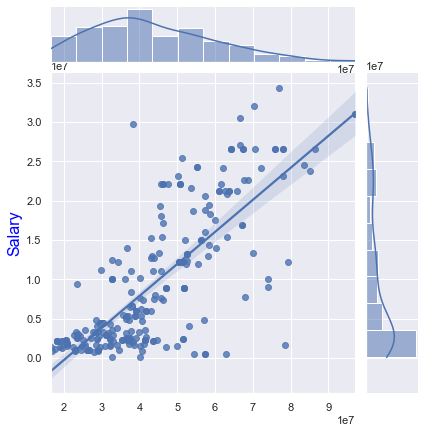

In [32]:
preds_test = lm_ridge.predict(X_test) # generate predictions (on test data) using fit model

plot_lm = sns.jointplot(x=preds_test,y=y_test,kind='reg')
plot_lm.set_axis_labels('', 'Salary', fontsize=16,color="blue")

In [33]:
list(zip(X_test.columns,lm_ridge.coef_))


[('2PT_M', 1682065.8106702007),
 ('3PT_M', 409975.4118864649),
 ('FT_M', 1280101.1693951613),
 ('DEF_REB', 1101506.2984288156),
 ('OFF_REB', -182726.25539543832),
 ('ASSISTS', 1118692.0203405295),
 ('STEALS', 6675.603614980096),
 ('TO', 234978.98993218408),
 ('EXPERIENCE', 3778636.1192931025),
 ('BLOCKS', -728815.5105614954),
 ('POSITION_PG', -492187.1120286777),
 ('POSITION_SG', 90078.66602341262),
 ('POSITION_PF', 22433.019402055666),
 ('POSITION_SF', -148316.4729066419),
 ('POSITION_C', 477833.76717601717)]

In [34]:
coef_list=list(zip(X.columns,lm_ridge.coef_))


<BarContainer object of 15 artists>

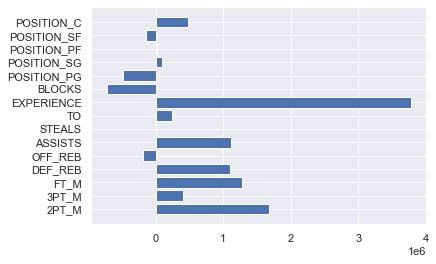

In [35]:
coef_df=pd.DataFrame(coef_list,columns = ['Feature',"Coefficient"])
coef_df
x_barplot = coef_df['Feature']
y_barplot = coef_df['Coefficient']

#negative coefs are for pos_sf,pos_pg,blocks,off_reb

plt.barh(x_barplot,y_barplot)

In [36]:
coef_dict=dict(zip(X.columns,lm_ridge.coef_))

for i,(key,coef) in enumerate(coef_dict.items()):
    if coef <0:
        coef = -coef
        coef_dict[key]=coef
coef_dict



{'2PT_M': 1682065.8106702007,
 '3PT_M': 409975.4118864649,
 'FT_M': 1280101.1693951613,
 'DEF_REB': 1101506.2984288156,
 'OFF_REB': 182726.25539543832,
 'ASSISTS': 1118692.0203405295,
 'STEALS': 6675.603614980096,
 'TO': 234978.98993218408,
 'EXPERIENCE': 3778636.1192931025,
 'BLOCKS': 728815.5105614954,
 'POSITION_PG': 492187.1120286777,
 'POSITION_SG': 90078.66602341262,
 'POSITION_PF': 22433.019402055666,
 'POSITION_SF': 148316.4729066419,
 'POSITION_C': 477833.76717601717}

In [37]:
coef_df = pd.DataFrame(list(coef_dict.items()),columns =['Feature','Coefficient'])
coef_df=coef_df.sort_values(by=['Coefficient'])
                        

Text(0.5, 1.0, 'Coefficient Magnitude')

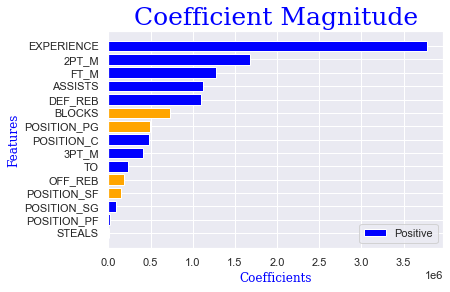

In [38]:
x_barplot = coef_df['Feature']
y_barplot = coef_df['Coefficient']

#negative coefs are for pos_sf,pos_pg,blocks,off_reb

plt.barh(x_barplot,y_barplot,color=['blue', 'blue', 'blue', 'orange', 'orange', 'blue', 'blue',
                    'blue', 'orange', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xlabel('Coefficients',fontsize = 20,color='blue',font = 'serif')
plt.ylabel('Features',fontsize = 20,color='blue',font = 'serif')
plt.legend(['Positive'],loc=4)
plt.title("Coefficient Magnitude",font = 'serif',fontsize = 25,color = 'blue')

In [39]:
preds_test = lm_ridge.predict(X_test)

RMSE = RMSE(y_test,preds_test)
RMSE

35969711.686699584

In [40]:
SSE=SSE(y_test,preds_test)
SSE

3.3251178081784326e+17

In [41]:
MAE = MAE(y_test,preds_test)
MAE

34183201.5116428

In [42]:
# y_pred = lm_ridge.predict(lm_ridge.intercept_)

# plt.scatter(y_pred,y-y_pred,alpha=opt_alpha)
# plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
# plt.xlabel('Predicted Value')
# plt.ylabel('Residual')
lm_ridge.intercept_

9316181.040935673

In [43]:
# # Lebron James example 
lebron_2020 = final_df[final_df['PLAYER']=="lebron james"].iloc[5:6]
lebron_2020

,PLAYER,GAMES,MINUTES_PLAYED,FIELD_GOALS,FIELD_GOAL_PCT,3PT_M,3PT_PCT,2PT_M,2PT_PCT,FT_M,...,POINTS,YEAR,TEAM_x,POSITION,EXPERIENCE,SALARY,EXPIRES,CONTRACT_LEN,CONTRACT_TOT,YEAR_SIGNED
904,lebron james,67,34.6,9.6,0.493,2.2,0.348,7.4,0.564,3.9,...,25.3,2020,LAL,PG,16.0,37436858.0,2023.0,2.0,85655532.0,2021.0


In [44]:
lebron_2020['POSITION_PG']=1
lebron_2020['POSITION_SG']=0
lebron_2020['POSITION_SF']=0
lebron_2020['POSITION_PF']=0
lebron_2020['POSITION_C']=0
features_example = ['2PT_M','3PT_M','FT_M','DEF_REB','OFF_REB','ASSISTS',
       'STEALS','TO','EXPERIENCE','BLOCKS','POSITION_PG','POSITION_SG','POSITION_SF','POSITION_PF',
                    'POSITION_C','SALARY']

y_lebron = lebron_2020[features_example].iloc[0:,-1:]
x_lebron = lebron_2020[features_example].iloc[0:,0:15]
y_lebron

,SALARY
904,37436858.0


In [48]:
# lebron_fit = lm_ridge.fit(x_lebron,y_lebron)

lebron_test =lm_ridge.predict(x_lebron)
int(lebron_test)
 # generate predictions (on test data) using fit model

# 42,827,766 is actual 

107012146

In [52]:
tatum_2020 = final_df[final_df['PLAYER']=="jayson tatum"].iloc[0:1]


tatum_2020

,PLAYER,GAMES,MINUTES_PLAYED,FIELD_GOALS,FIELD_GOAL_PCT,3PT_M,3PT_PCT,2PT_M,2PT_PCT,FT_M,...,POINTS,YEAR,TEAM_x,POSITION,EXPERIENCE,SALARY,EXPIRES,CONTRACT_LEN,CONTRACT_TOT,YEAR_SIGNED
208,jayson tatum,66,34.3,8.4,0.45,2.9,0.403,5.5,0.48,3.8,...,23.4,2020,BOS,PF,2.0,7830000.0,2026.0,5.0,163000300.0,2021.0


In [53]:
tatum_2020['POSITION_PG']=0
tatum_2020['POSITION_SG']=0
tatum_2020['POSITION_SF']=0
tatum_2020['POSITION_PF']=1
tatum_2020['POSITION_C']=0
features_example = ['2PT_M','3PT_M','FT_M','DEF_REB','OFF_REB','ASSISTS',
       'STEALS','TO','EXPERIENCE','BLOCKS','POSITION_PG','POSITION_SG','POSITION_SF','POSITION_PF',
                    'POSITION_C','SALARY']

y_tatum = tatum_2020[features_example].iloc[0:,-1:]
x_tatum = tatum_2020[features_example].iloc[0:,0:15]
y_tatum

,SALARY
208,7830000.0


In [61]:
#current salary on ESPN site is 28.1M

print('Tatum"s current contract pays him 28,100,00 a year our model predicted'+ 
      " "+ str(int(lm_ridge.predict(x_tatum))))

Tatum"s current contract pays him 28,100,00 a year our model predicted 41706063
